# Giant number fluctuations in active turbulence

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor, bpass, wowcolor
from skimage import io, measure
import pandas as pd
from scipy.signal import savgol_filter, medfilt
import os
import corrLib as cl
from numpy.polynomial.polynomial import polyvander
from scipy.optimize import curve_fit
from miscLib import label_slope
from scipy import signal
from scipy.interpolate import griddata
import matplotlib
import pandas as pd

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = 10, 6
matplotlib.rcParams['font.family'] = 'serif'

* Preliminary result - one set of videos

Text(0, 0.5, '$\\Delta N/\\sqrt{N}$')

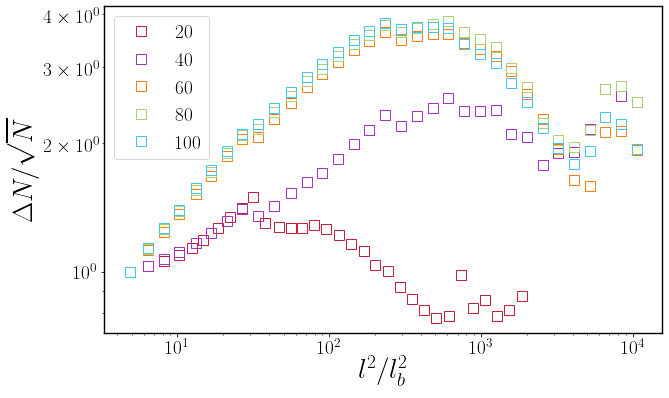

In [16]:
data = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig2-GNF\GNF_data.csv')
lb = 3 # um
mpp = 0.33 
count = 0
slopeL = []
for name in data.Name.drop_duplicates():
    subdata = data.loc[data.Name==name]    
    # to plot, xx yy
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5 
    yy = yy / yy.iat[0]
    plt.plot(xx[0:len(xx):3], yy[0:len(yy):3], label=str(name), ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
    # to fit
    x = xx.loc[xx<2e1]
    y = yy.loc[xx<2e1] 
    xf, yf, xt, yt, slope = label_slope(x, y, location='n')
#     plt.plot(xf, yf, ls='--', color='black')
#     plt.text(xt, yt, '{:.2f}'.format(slope))
    count += 1
    slopeL.append(slope)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/l_b^2$')
plt.ylabel('$\Delta N/\sqrt{N}$')

Text(0, 0.5, 'slope')

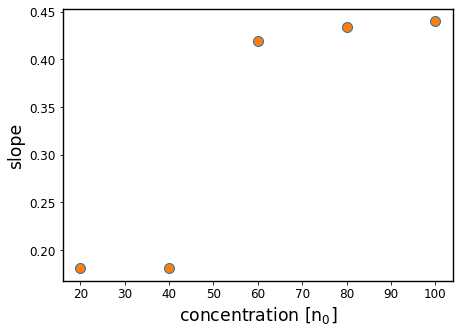

In [8]:
n = [20, 40, 60, 80, 100]
plt.figure(figsize=(7, 5))
plt.plot(n, slopeL, ls='', marker='o', mfc=wowcolor(2),
        markersize=10, lw='2')
plt.xlabel('concentration [n$_0$]')
plt.ylabel('slope')

* Improved data - multiple repeats

## Alternative method for DF

Text(10, 2.558336368008464, '0.5')

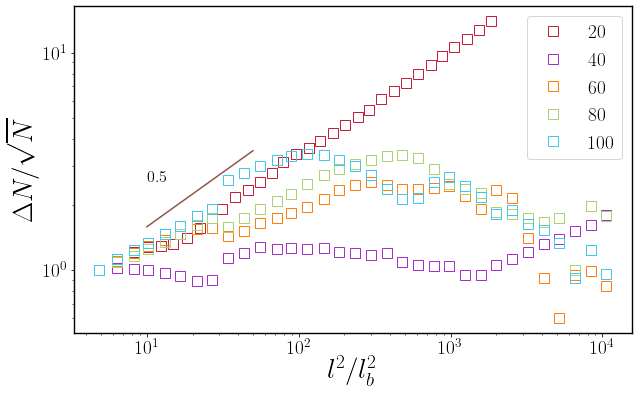

In [27]:
lb = 3 # um
mpp = 0.33 # um per pixel
folder = r'D:\Wei\Dynamics_raw\df2_result'
names = ['20', '40', '60', '80', '100']
count = 0
for name in names:
    subdata = pd.read_csv(os.path.join(folder, name, 'df_average.csv'))
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5 
    yy = yy / yy.iat[0]
    plt.plot(xx[0:len(xx):3], yy[0:len(yy):3], label=str(name), ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
    count += 1
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/l_b^2$')
plt.ylabel('$\Delta N/\sqrt{N}$')

# guide of the eye slope
x = np.array([10, 50])
y = x**0.5 / 2
plt.plot(x, y)
plt.text(x[0], y.mean(), '0.5')

__Comment__: the kinks for all the curves happen at $l^2/l_b^2\approx25$, which corresponds to $l\approx45$ pixels. This value does not agree with the bpass parameter (100 px), and thus it should not be a result from image preprocessing. However, all kinks happens at the same $l$ is indeed suspicious. 

# What if no bpass?

Text(10, 2.558336368008464, '0.5')

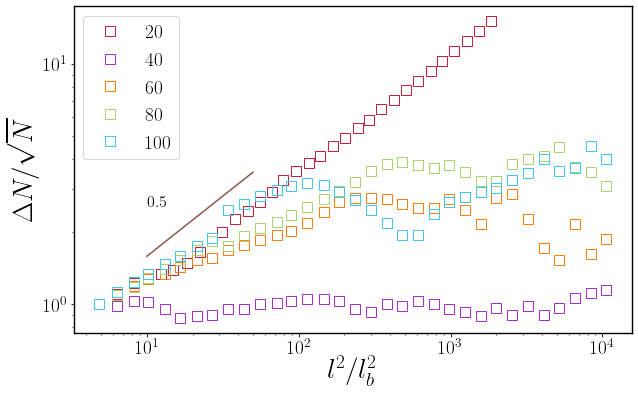

In [26]:
lb = 3 # um
mpp = 0.33 # um per pixel
folder = r'D:\Wei\Dynamics_raw\df2nobp_result'
names = ['20', '40', '60', '80', '100']
count = 0
for name in names:
    subdata = pd.read_csv(os.path.join(folder, name, 'df_average.csv'))
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5 
    yy = yy / yy.iat[0]
    plt.plot(xx[0:len(xx):3], yy[0:len(yy):3], label=str(name), ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
    count += 1
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/l_b^2$')
plt.ylabel('$\Delta N/\sqrt{N}$')

# guide of the eye slope
x = np.array([10, 50])
y = x**0.5 / 2
plt.plot(x, y)
plt.text(x[0], y.mean(), '0.5')

<b style='color:green'>Comment:</b> no bpass make the kinks in 40, 60 and 80 curves much less pronounced. 100 curve does not get better much. This indicates that most kinks are indeed induced by bpass, but for some curves, the cause of the kink is still a puzzle. 

<b style='color:red'>Comment:</b> The large slope of 20 curve is anomalous, but not surprising. At 20 n$_0$, the bacterial suspension barely display the cluster-like black spots. Individual bacterium can be seen and the image intensity variation within single bacterium body dominates the intensity variation in the image - rather than the concentration. Therefore, I don't apply GNF based on image intensity for low concentration suspensions in the future. 

__Thought__: Spatial and temporal variations are equivalent in a homogeneous dynamical system. Necessary conditions are: long enough time for temporal variation evaluation, and large enough box for spatial variation evaluation. 

_Science_ __320__, 612.

# Try new 20 (and 10) n0 data from 03032020
The 20 n$_0$ data does not agree with the trend exhibited by other data. I suspect that the image intensity - concentration relation breaks up when concentration is low. Here I use an independent experiment to verify this hypothesis. 

In [32]:
def average_NF(folder, avrange=[250, 500]):
    l = cl.readdata(folder)
    count = 0
    for num, i in l.iterrows():
        if int(i.Name) < avrange[0] or int(i.Name) > avrange[1]:
            continue
        tmp = pd.read_csv(i.Dir)
        if count == 0:
            data = tmp
        else:
            data += tmp
        count += 1
    return data / count

Text(10, 2.558336368008464, '0.5')

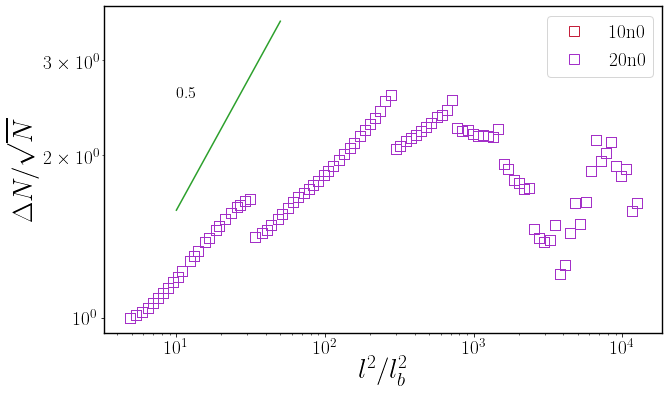

In [58]:
# Method I
names = ['10n0', '20n0']
master_folder = r'D:\Data\03032020\df_result'
count = 0
for name in names:
    forder = os.path.join(master_folder, name)
    subdata = average_NF(folder, avrange=[0, 600])
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5 
    yy = yy / yy.iat[0]
    plt.plot(xx[0:len(xx):1], yy[0:len(yy):1], label=name, ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
    count += 1
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/l_b^2$')
plt.ylabel('$\Delta N/\sqrt{N}$')


# guide of the eye slope
x = np.array([10, 50])
y = x**0.5 / 2
plt.plot(x, y)
plt.text(x[0], y.mean(), '0.5')

<b>Note:</b> 10 n$_0$ and 20 n$_0$ data completely overlap. I have checked the calculations and they don't show obvious error. Why this happened is still a puzzle.

<b style="color: green">Comment:</b> The result above, where the initial fluctuations grow much faster than subsystem size, is contradicting our knowledge that "low density suspensions should not show GNF". Therefore, we stop using this method to quantify density fluctuation in dilute suspensions.

Text(10, 2.558336368008464, '0.5')

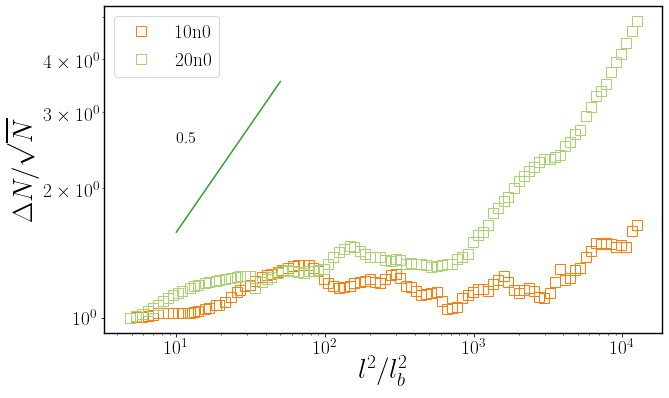

In [61]:
# Method II, alternative method is also used to quantify the GNF in dilute suspensions.
names = ['10n0', '20n0']
master_folder = r'D:\Data\03032020\df2nobp_result'
for name in names:
    subdata = pd.read_csv(os.path.join(master_folder, name, 'df_average.csv'))
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5 
    yy = yy / yy.iat[0]
    plt.plot(xx[0:len(xx):1], yy[0:len(yy):1], label=name, ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
    count += 1
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/l_b^2$')
plt.ylabel('$\Delta N/\sqrt{N}$')


# guide of the eye slope
x = np.array([10, 50])
y = x**0.5 / 2
plt.plot(x, y)
plt.text(x[0], y.mean(), '0.5')

<b style="color:green">Comments:</b> verification run at 10, 20 n$_0$ shows low deviation from CLT, relative to high concentrations.

# Redo 02042020 analysis
I have done triplicates for GNF project on 02042020. The result looks strange, in particular, all GNF curves show very similar behavior. It turns out that the similar results of GNF analysis are likely to be a result of auto-contrast before calculation (by accident). Below I redo the calculation on images without auto-contrast. Hopefully, this will resolve the issue.

In [189]:
# Method I
master_folder = r'D:\Wei\02042020\df_result'
names = next(os.walk(master_folder))[1]
data = {}
count = {}
for name in names:
    l = cl.readdata(os.path.join(master_folder, name))
    frame_count = 0
    for num, i in l.iterrows():
        if num > 100:
            break
        if num == 0:
            frame_data = pd.read_csv(i.Dir)
        else:
            frame_data += pd.read_csv(i.Dir)
        frame_count += 1
    subdata = frame_data / frame_count
    conc = str(name.split('-')[0])
    if conc in data.keys():
        data[conc] += subdata
        count[conc] += 1
    else:
        data[conc] = subdata
        count[conc] = 1

In [184]:
count

{'20': 3, '40': 3, '60': 3, '80': 3}

Text(18.0, 2.558336368008464, '0.5')

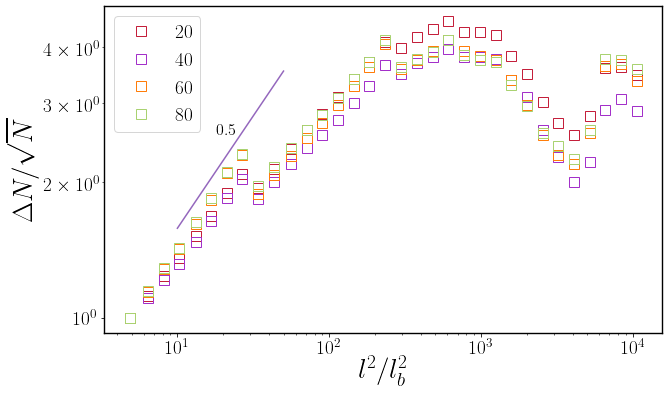

In [188]:
# 20, 40, 60 and 80 n0 curves
k = 0
for kw in data:
    subdata = data[kw] / count[kw]    
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5
    yy = yy / yy.iat[0]
    plt.plot(xx[0:len(xx):3], yy[0:len(yy):3], label=kw, ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(k), markersize=10)
    k += 1
# plot display details
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/l_b^2$')
plt.ylabel('$\Delta N/\sqrt{N}$')

# guide of the eye slope
x = np.array([10, 50])
y = x**0.5 / 2
plt.plot(x, y)
plt.text(0.8*x[0]+0.2*x[1], y.mean(), '0.5')

<b style="color:red">Comment:</b> Method I on new data shows similar scaling for all different concentrations. This is different from method II, where concentration clearly affects the scaling. This is puzzling. 

Text(0, 0.5, '$\\Delta N/\\sqrt{N}$')

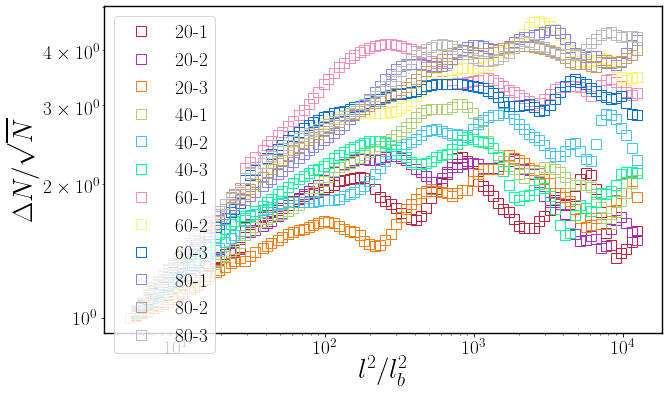

In [119]:
# Method II, alternative method is also used to quantify the GNF in dilute suspensions.
master_folder = r'D:\Wei\02042020\df2nobp_result'
names = next(os.walk(master_folder))[1]
count = 0
for name in names:
    subdata = pd.read_csv(os.path.join(master_folder, name, 'df_average.csv'))
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5    
    yy = yy / yy.iat[0]
    plt.plot(xx[0:len(xx):1], yy[0:len(yy):1], label=name, ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
    count += 1
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/l_b^2$')
plt.ylabel('$\Delta N/\sqrt{N}$')

# guide of the eye slope
# x = np.array([10, 50])
# y = x**0.5 / 2
# plt.plot(x, y)
# plt.text(x[0], y.mean(), '0.5')

In [29]:
# Combine measurements at same concentration (20, 40, 60, 80)
master_folder = r'E:\moreData\02042020\df2nobp_result'
names = next(os.walk(master_folder))[1]
data = {}
count = {}
for name in names:    
    subdata = pd.read_csv(os.path.join(master_folder, name, 'df_average.csv'))
    conc = str(name.split('-')[0])
    if conc in data.keys():
        data[conc] += subdata
        count[conc] += 1
    else:
        data[conc] = subdata
        count[conc] = 1

Text(18.0, 2.558336368008464, '0.5')

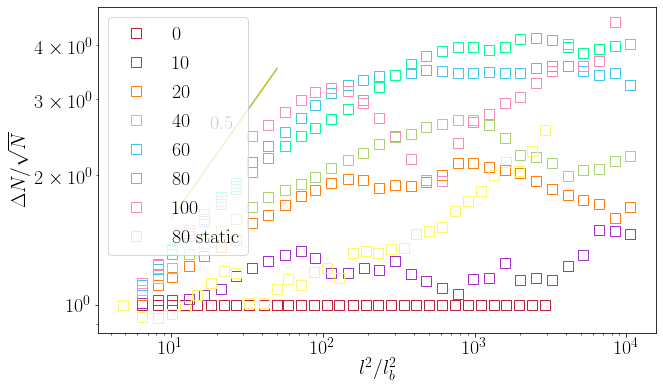

In [42]:
# Run the block above before running this one
k = 0

# Hypothetical 0 n0 GNF curve
xx = subdata.n / (lb/mpp)**2
yy = subdata.d / subdata.n**.5
yy /= yy
plt.plot(xx[0:len(xx):3], yy[0:len(yy):3], label='0', ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(k), markersize=10) 
k += 1

# 10 n0 curve
names = ['10n0']
master_folder = r'E:\moreData\03032020\df2nobp_result'
for name in names:
    subdata = pd.read_csv(os.path.join(master_folder, name, 'df_average.csv'))
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5 
    yy = yy / yy.iat[0]
    plt.plot(xx[0:len(xx):3], yy[0:len(yy):3], label='10', ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(k), markersize=10)
    k += 1

# 20, 40, 60 and 80 n0 curves
for kw in data:
    subdata = data[kw] / count[kw]    
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5
    yy = yy / yy.iat[0]
    plt.plot(xx[0:len(xx):3], yy[0:len(yy):3], label=kw, ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(k), markersize=10)
    k += 1  

# 100 n0 curve
names = ['100']
master_folder = r'E:\moreData\Dynamics_raw\df2nobp_result'
for name in names:
    subdata = pd.read_csv(os.path.join(master_folder, name, 'df_average.csv'))
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5 
    yy = yy / yy.iat[0]
    plt.plot(xx[0:len(xx):3], yy[0:len(yy):3], label='100', ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(k), markersize=10)
    k += 1

# Adding a static 80 n0 curve
folder1 = r'E:\moreData\df2nobp_result_16bit\No.1P_static'
subdata = pd.read_csv(os.path.join(folder1, 'df_average.csv'))
xx = subdata.n / (lb/mpp)**2
yy = subdata.d / subdata.n**.5
yy = yy / yy.iat[0]
xx = xx[0:len(xx):3]
yy = yy[0:len(yy):3]
plt.plot(xx, yy, label='80 static', ls='', marker='s', 
        mfc=(0,0,0,0), mec=wowcolor(k), markersize=10)
    
# plot display details
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/l_b^2$')
plt.ylabel('$\Delta N/\sqrt{N}$')

# guide of the eye slope
x = np.array([10, 50])
y = x**0.5 / 2
plt.plot(x, y)
plt.text(0.8*x[0]+0.2*x[1], y.mean(), '0.5')

Text(0, 0.5, '$\\alpha$')

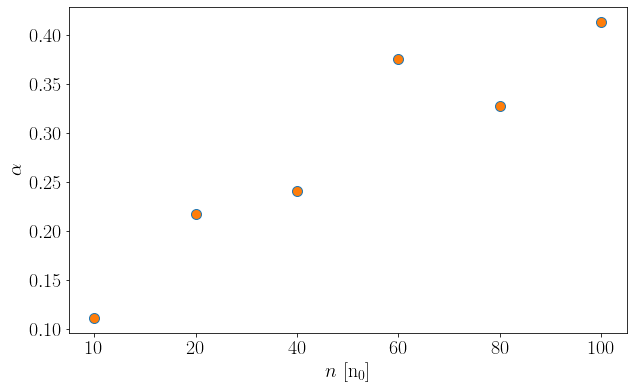

In [19]:
# Concentration GNF slope
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\data\GNF\slope_concentration.csv')
data = data.drop(index=6)
plt.plot(data.conc, data.slope, ls='', marker='o', mfc=wowcolor(2),
        markersize=10, lw='2')
plt.xlabel('$n$ [n$_0$]')
plt.ylabel('$\\alpha$')

In [11]:
data

,conc,slope
0,10,0.110467
1,20,0.217378
2,40,0.240828
3,60,0.375137
4,80,0.326918
5,100,0.412935
6,80s,0.070047


<b style="color:green">Comment:</b> Calculation of GNF using method II shows interesting results. Below the critical concentration for active turbulence (40 n$_0$), the deviation from CLT is small, yet increasing with concentration. Above the critical concentration, however, the deviation becomes independent of concentration. This observation indicates that, at low concentration, bacteria start to exhibit a correlation, which leads to dynamic clustering, in a weak manner. At high concentration, the correlation saturates.

<i>PRL</i> <b>119,</b> 028005 (2017)

# Using method II to calculate kinetics

In [15]:
folder = r'E:\moreData\05282020\00\8-bit'
l = cl.readseq(folder)
seg = range(0, 2000, 200)

In [16]:
img = io.imread(l.Dir.loc[0])
size_min = 20
L = min(img.shape)
boxsize = np.unique(np.floor(np.logspace(np.log10(size_min),
                    np.log10((L-size_min)/2),50)))

In [17]:
data = pd.DataFrame()
for idx in range(1, len(seg)):
    subdata = l.loc[(l.index>=seg[idx-1])&(l.index<seg[idx])]
    df = pd.DataFrame()
    for num, i in subdata.iterrows():
        img = io.imread(i.Dir)
        framedf = pd.DataFrame()
        for bs in boxsize: 
            X, Y, I = cl.divide_windows(img, windowsize=[bs, bs], step=50*size_min)
            tempdf = pd.DataFrame().assign(I=I.flatten(), t=int(i.Name), size=bs, 
                           number=range(0, len(I.flatten())))
            framedf = framedf.append(tempdf)
        df = df.append(framedf)
    df_out = pd.DataFrame()
    for number in df.number.drop_duplicates():
        subdata1 = df.loc[df.number==number]
        for s in subdata1['size'].drop_duplicates():
            subdata = subdata1.loc[subdata1['size']==s] 
            d = s**2 * np.log(np.array(subdata.I)).std()
            n = s**2 
            tempdf = pd.DataFrame().assign(n=[n], d=d, size=s, number=number)
            df_out = df_out.append(tempdf)
    average = pd.DataFrame()
    for s in df_out['size'].drop_duplicates():
        subdata = df_out.loc[df_out['size']==s]
        avg = subdata.drop(columns=['size', 'number']).mean().to_frame().T
        average = average.append(avg)
    data = data.append(average.assign(frame=idx))

Text(180.0, 8.090169943749475, '0.5')

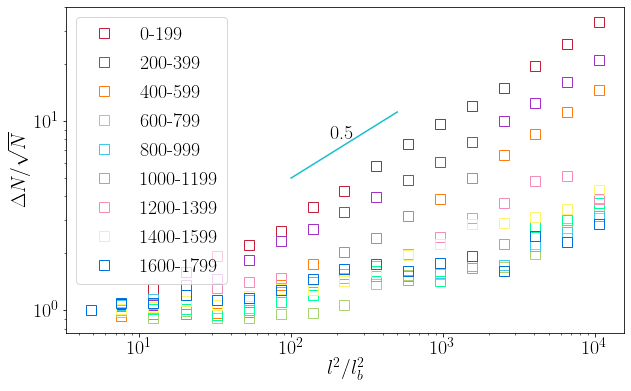

In [24]:
lb = 3
mpp = 0.33
k = 0
for idx in data.frame.drop_duplicates():
    subdata = data.loc[data.frame==idx]
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5
    yy = yy / yy.iat[0]
    plt.plot(xx[0:len(xx):3], yy[0:len(yy):3], label='{:d}-{:d}'.format((idx-1)*200, idx*200-1), ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(k), markersize=10)
    k += 1
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/l_b^2$')
plt.ylabel('$\Delta N/\sqrt{N}$')

# guide of the eye slope
x = np.array([100, 500])
y = x**0.5 / 2
plt.plot(x, y)
plt.text(0.8*x[0]+0.2*x[1], y.mean(), '0.5')

Text(6.2, 1.5424146577375526, '0.5')

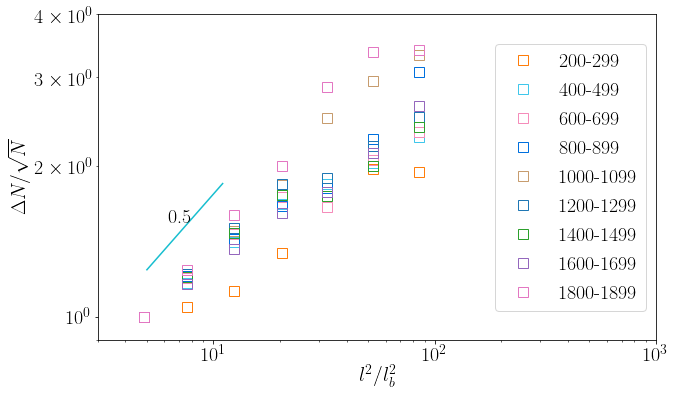

In [66]:
data = pd.read_csv(r'E:\moreData\transient\df2_kinetics\100\kinetics_data.csv')
lb = 3
mpp = 0.33
k = 0
seg_length = 100
for idx in data.segment.drop_duplicates():
    if k == 0:
        k += 1
        continue
    if k % 2 != 0:
        k += 1
        continue
    subdata = data.loc[data.segment==idx]
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5
    yy = yy / yy.iat[0]
    # plot less points
    xx = xx[0:len(xx):3]
    yy = yy[0:len(yy):3]
    plt.plot(xx[xx<100], yy[xx<100], label='{:d}-{:d}'.format((idx-1)*seg_length, idx*seg_length-1), ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(k), markersize=10)
    k += 1
plt.axis([3, 1e3, 0.9, 4])
plt.legend(loc='center right', bbox_to_anchor=(1, 0.5),
          ncol=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/l_b^2$')
plt.ylabel('$\Delta N/\sqrt{N}$')

# guide of the eye slope
x = np.array([5, 11])
y = x**.5/1.8
plt.plot(x, y)
plt.text(0.8*x[0]+0.2*x[1], y.mean(), '0.5')

In [18]:
def powerlaw(x, a, b):
    return a*x**b

Text(0, 0.5, 'slope')

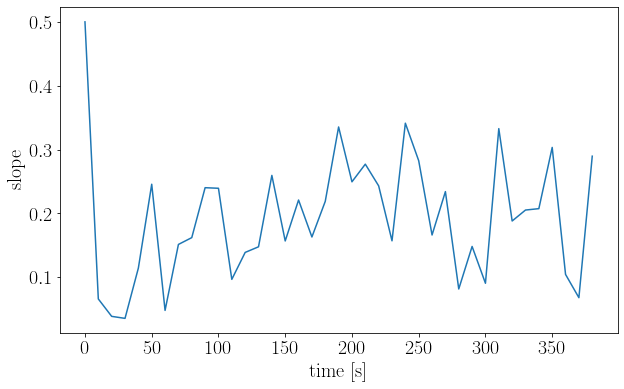

In [11]:
# fitting
data = pd.read_csv(r'E:\moreData\06232020\df2_kinetics\04\kinetics_data.csv')
lb = 3
mpp = 0.33
k = 0
seg_length = 100
fps = 10
frame = []
power = []
for idx in data.segment.drop_duplicates():
    subdata = data.loc[data.segment==idx]
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5
    yy = yy / yy.iat[0]
    index = xx < 100
    xx = xx[index]
    yy = yy[index]
    x = np.log(xx)
    y = np.log(yy)
    p = np.polyfit(x, y, deg=1)
    frame.append((idx-1)*seg_length/fps)
    power.append(p[0])
# plt.axis([-50, 1800, -0.03, 0.5])
plt.plot(frame, power)
plt.xlabel('time [s]')
plt.ylabel('slope')

Text(6.2, 1.5424146577375526, '0.5')

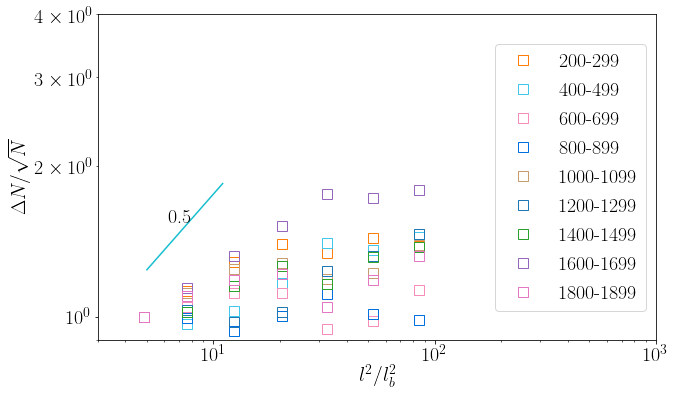

In [16]:
# 06092020 data
data = pd.read_csv(r'E:\moreData\06162020\df2_kinetics\00\kinetics_data.csv')
lb = 3
mpp = 0.33
k = 0
seg_length = 100
for idx in data.segment.drop_duplicates():
    if k == 0:
        k += 1
        continue
    if k % 2 != 0:
        k += 1
        continue
    subdata = data.loc[data.segment==idx]
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5
    yy = yy / yy.iat[0]
    # plot less points
    xx = xx[0:len(xx):3]
    yy = yy[0:len(yy):3]
    plt.plot(xx[xx<100], yy[xx<100], label='{:d}-{:d}'.format((idx-1)*seg_length, idx*seg_length-1), ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(k), markersize=10)
    k += 1
plt.axis([3, 1e3, 0.9, 4])
plt.legend(loc='center right', bbox_to_anchor=(1, 0.5),
          ncol=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/l_b^2$')
plt.ylabel('$\Delta N/\sqrt{N}$')

# guide of the eye slope
x = np.array([5, 11])
y = x**.5/1.8
plt.plot(x, y)
plt.text(0.8*x[0]+0.2*x[1], y.mean(), '0.5')

Text(18.0, 2.558336368008464, '0.5')

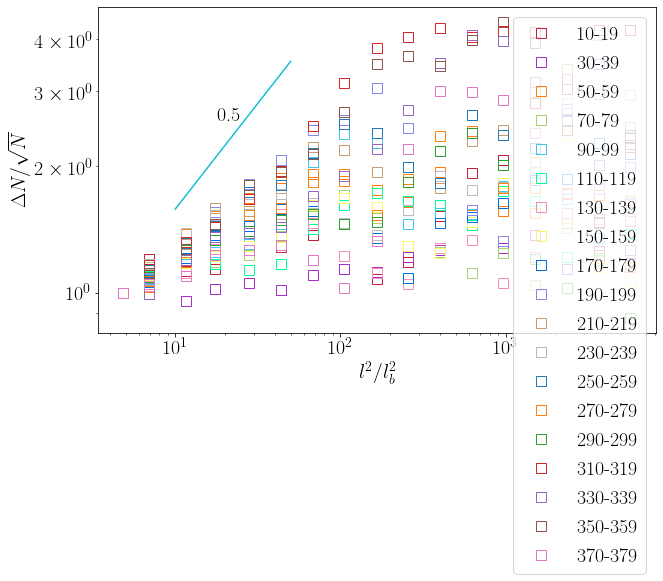

In [9]:
data = pd.read_csv(r'E:\moreData\06232020\df2_kinetics\04\kinetics_data.csv')
lb = 3
mpp = 0.33
k = 0
for idx in data.segment.drop_duplicates():
    if idx % 2 != 0:
        continue
    subdata = data.loc[data.segment==idx]
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5
    yy = yy / yy.iat[0]
    plt.plot(xx[0:len(xx):3], yy[0:len(yy):3], label='{:d}-{:d}'.format((idx-1)*10, idx*10-1), ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(k), markersize=10)
    k += 1
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/l_b^2$')
plt.ylabel('$\Delta N/\sqrt{N}$')

# guide of the eye slope
x = np.array([10, 50])
y = x**0.5 / 2
plt.plot(x, y)
plt.text(0.8*x[0]+0.2*x[1], y.mean(), '0.5')

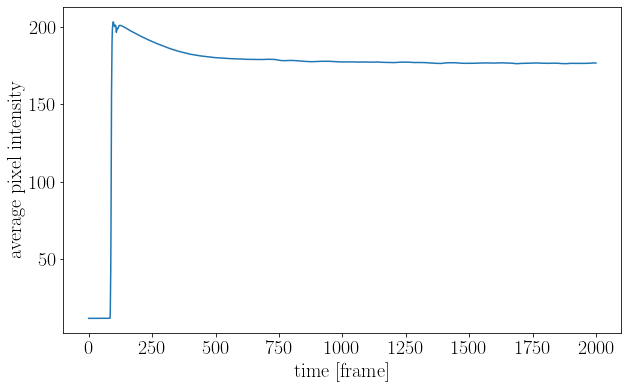

In [5]:
data = pd.read_csv(r'E:\moreData\06092020\overall_intensity\03\intensity.csv')
plt.plot(data.t, data.intensity)
plt.xlabel('time [frame]')
plt.ylabel('average pixel intensity')

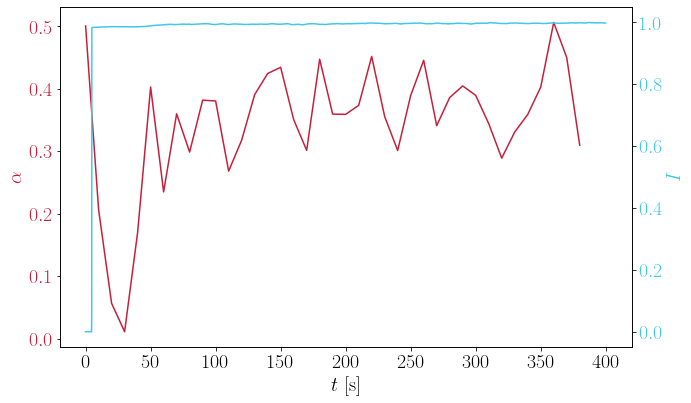

In [33]:
# plot evolution of number fluctuation exponents and light intensity on a same yyplot
# refer to https://matplotlib.org/gallery/api/two_scales.html

# load data
k_data = pd.read_csv(r'E:\moreData\06232020\df2_kinetics\01\kinetics_data.csv')
i_data = pd.read_csv(r'E:\moreData\06232020\overall_intensity\01\intensity.csv')

# set up constants
lb = 3
mpp = 0.33
seg_length = 100 # pay special attention since this is arbitrarily set to be 100, and practically can be any value
fps = 10 # pay special attention since this is different for different videos
t = [] 
power = []

# compute exponents at different time
# t, power will be plotted on ax1
for idx in k_data.segment.drop_duplicates():
    subdata = k_data.loc[k_data.segment==idx]
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5
    yy = yy / yy.iat[0]
    index = xx < 100
    xx = xx[index]
    yy = yy[index]
    x = np.log(xx)
    y = np.log(yy)
    p = np.polyfit(x, y, deg=1)
    t.append((idx-1)*seg_length/fps)
    power.append(p[0])

# rescale light intensity to (0, 1)
# t1, i will be plotted on ax2
t1 = i_data.t / fps
i = i_data.intensity - i_data.intensity.min()
i = i / i.max()

# set up fig and ax
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# plot t, power
color = wowcolor(0)
ax1.set_xlabel('$t$ [s]')
ax1.set_ylabel('$\\alpha$', color=color)
ax1.plot(t, power, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# plot t1, intensity
color = wowcolor(4)
ax2.set_ylabel('$I$', color=color)
ax2.plot(t1, i, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

E:\anaconda\miniconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
E:\anaconda\miniconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
E:\anaconda\miniconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see

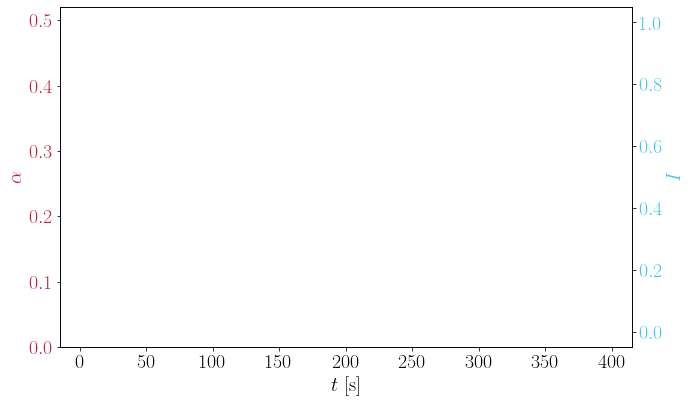

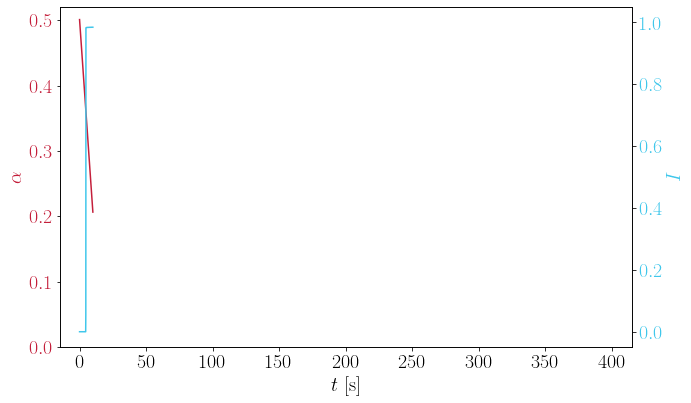

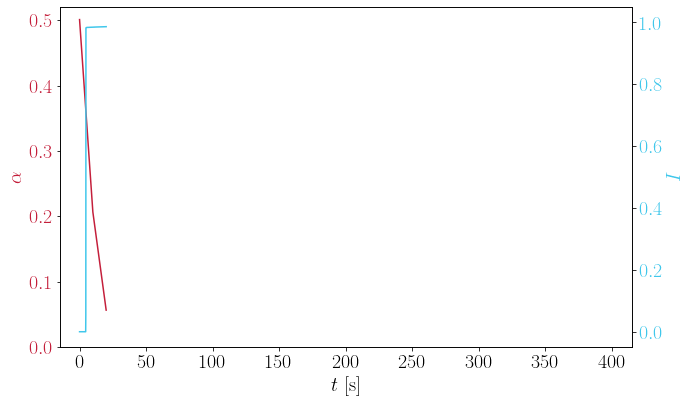

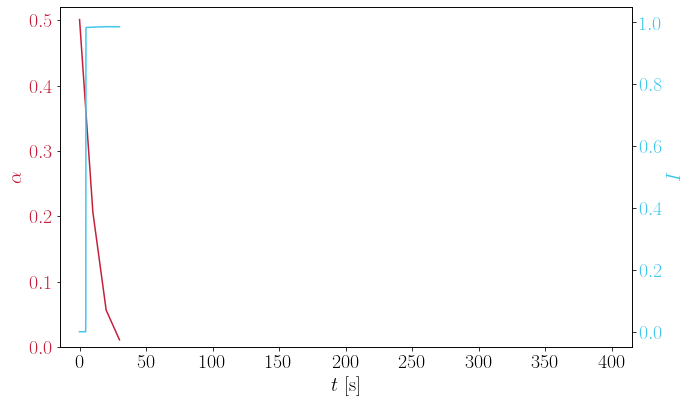

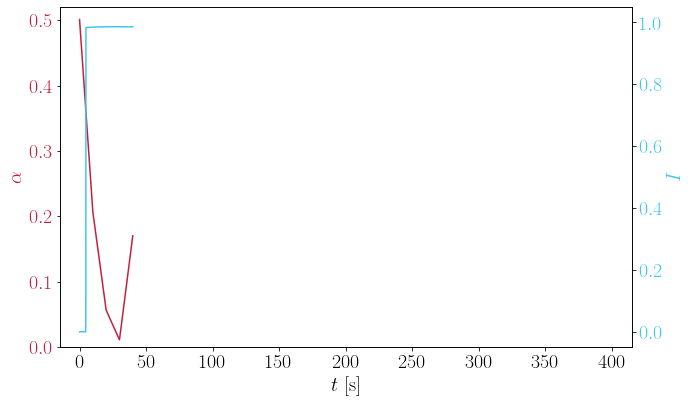

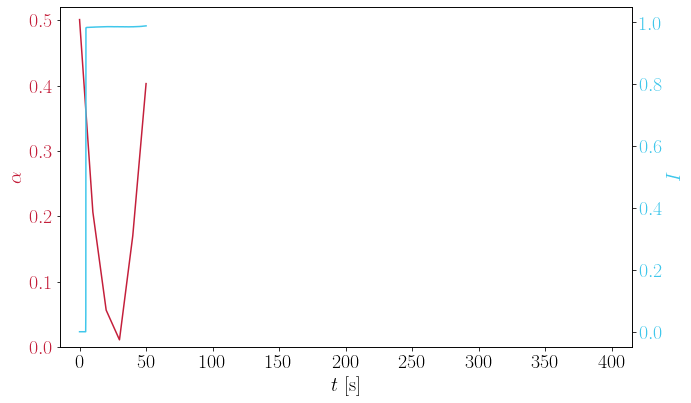

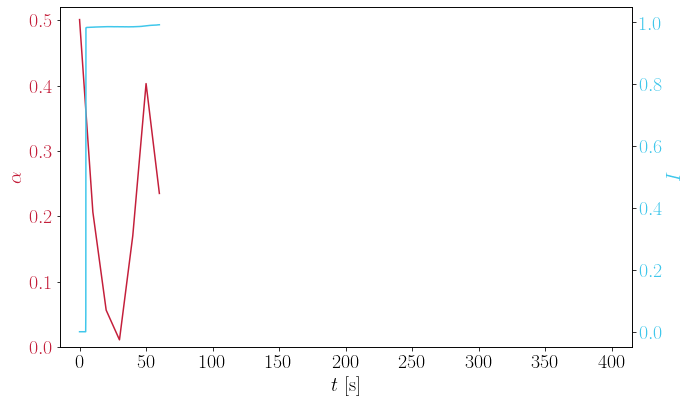

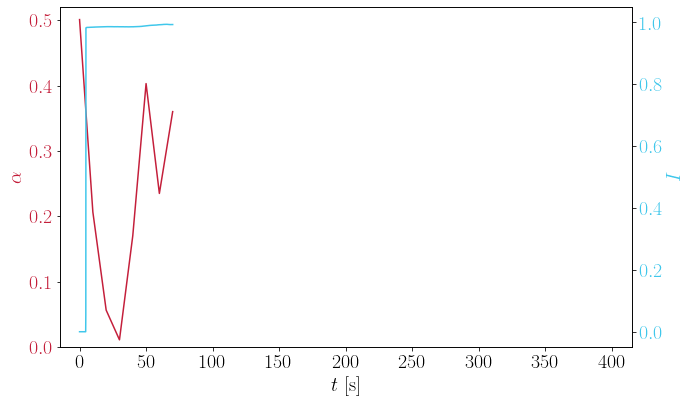

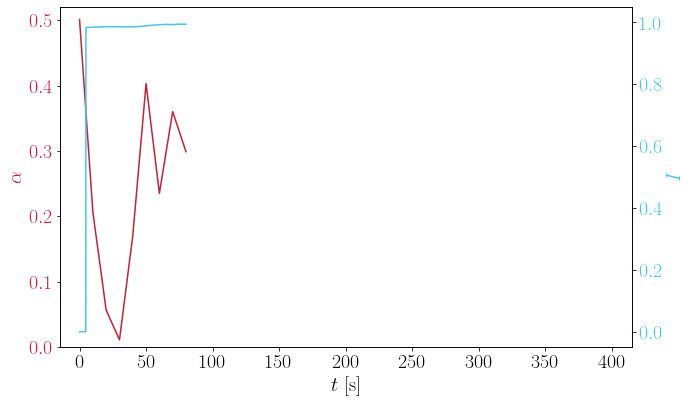

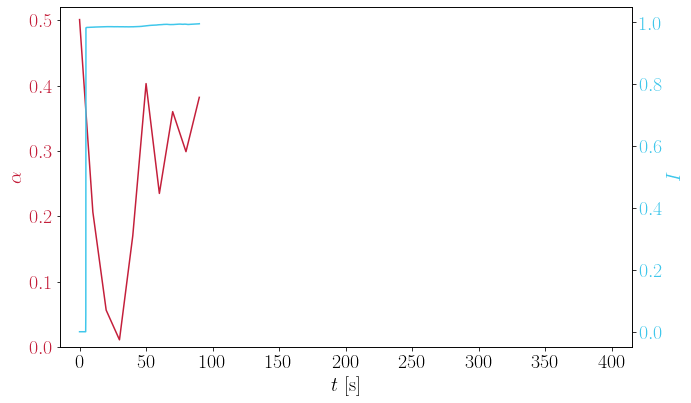

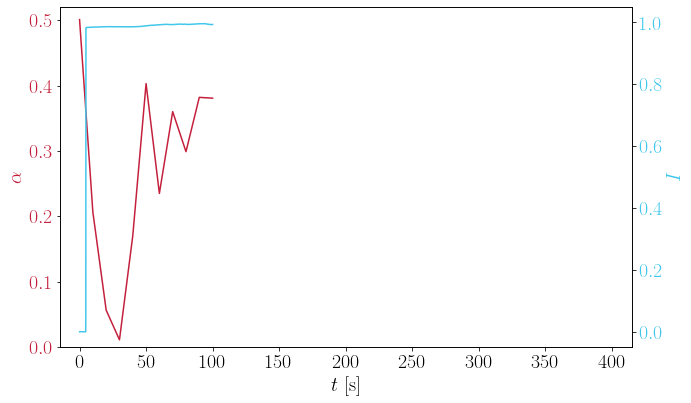

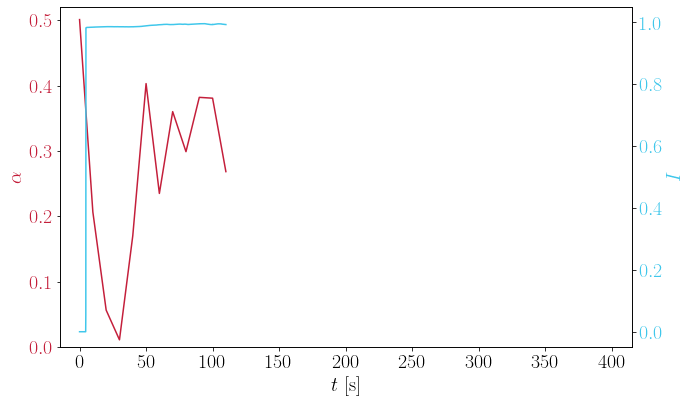

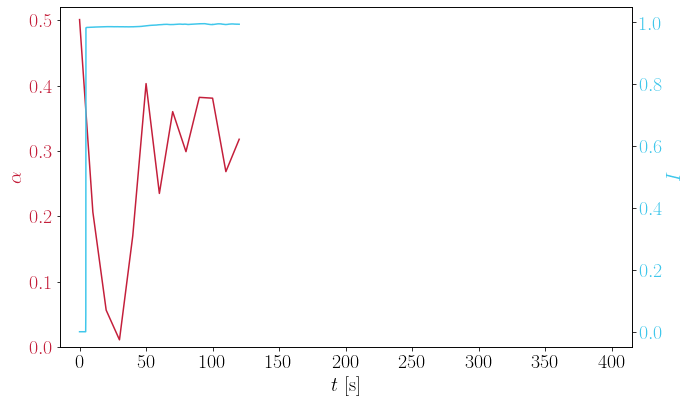

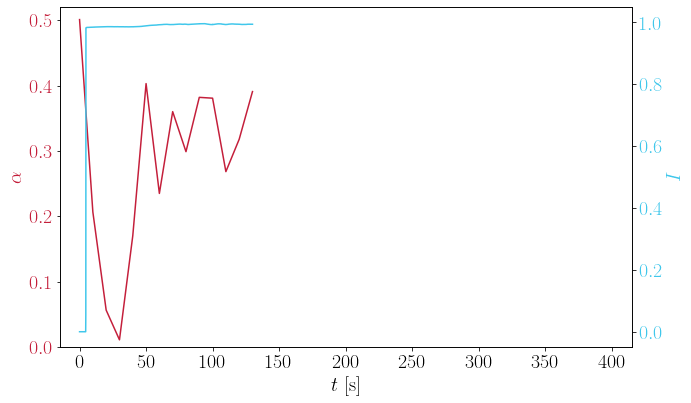

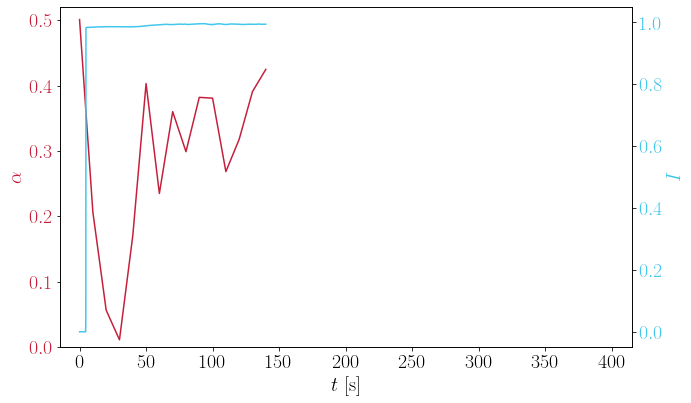

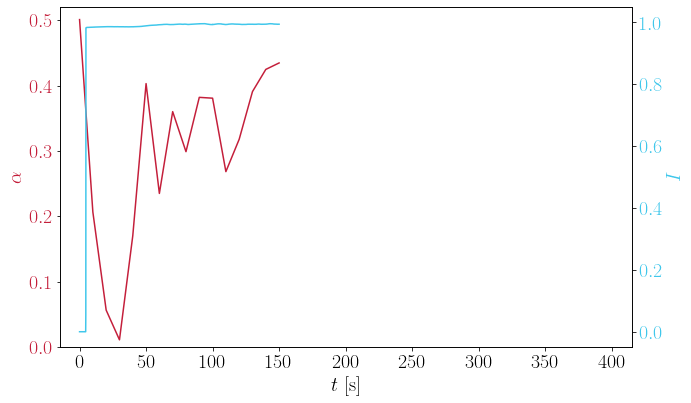

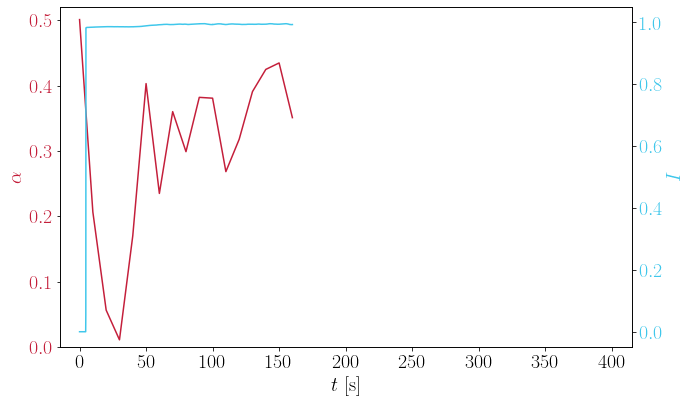

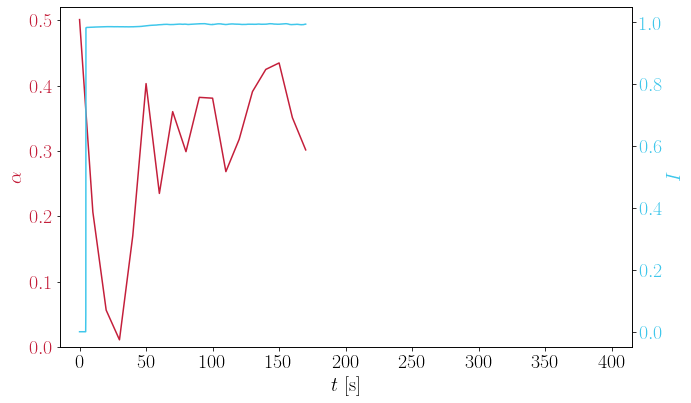

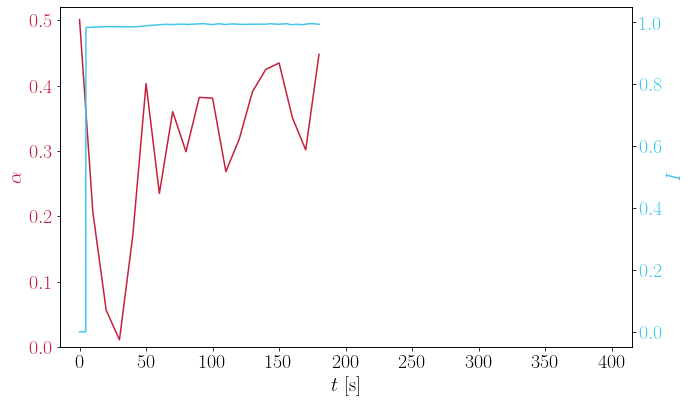

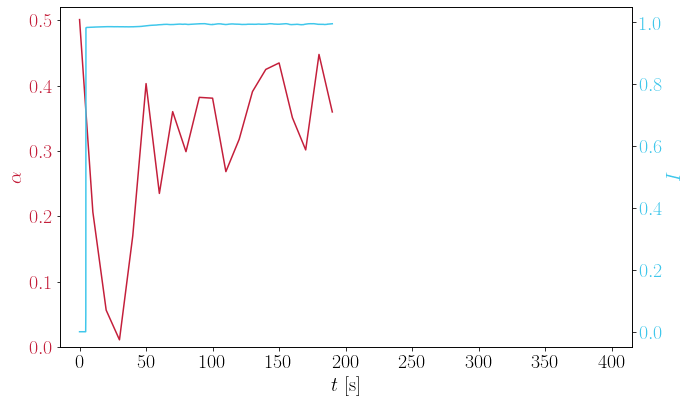

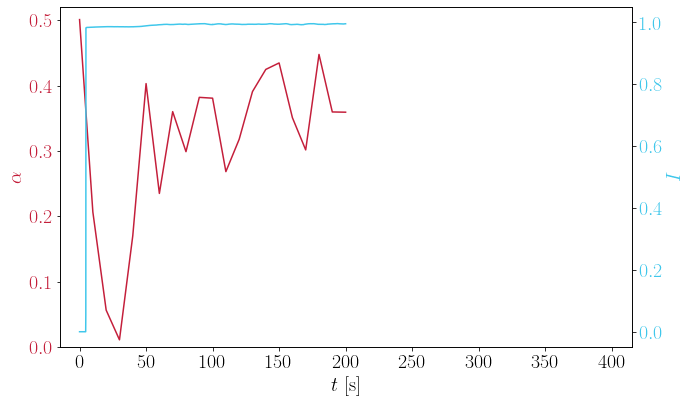

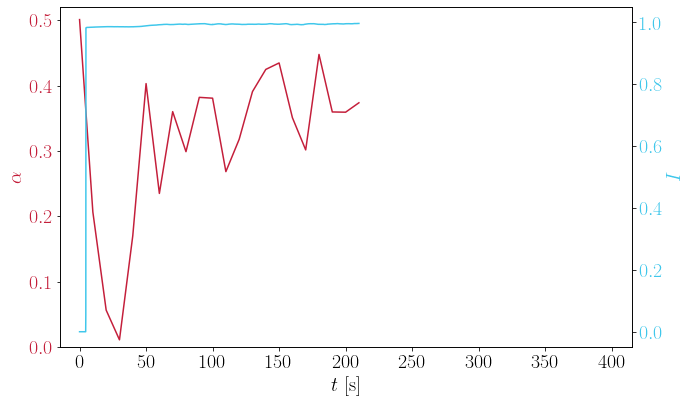

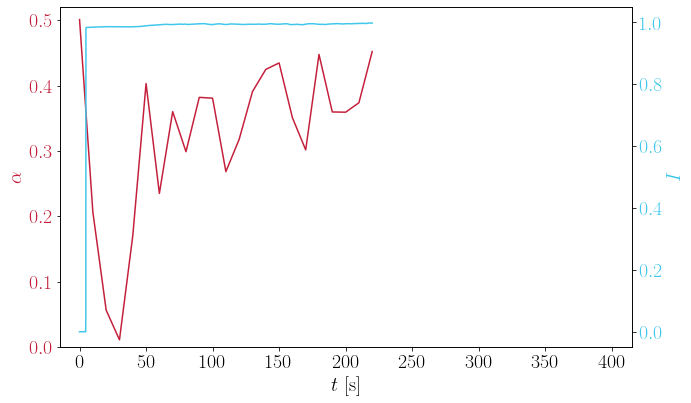

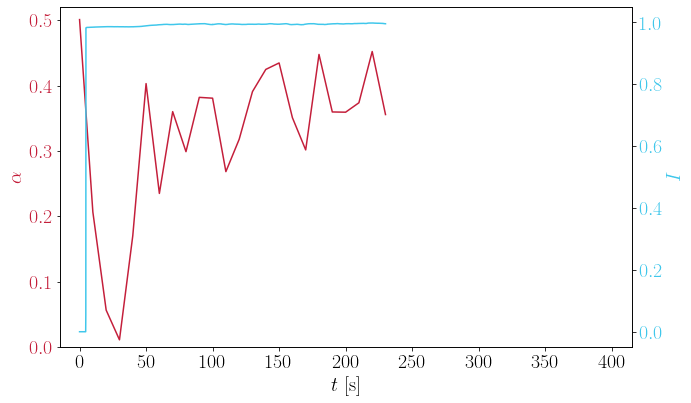

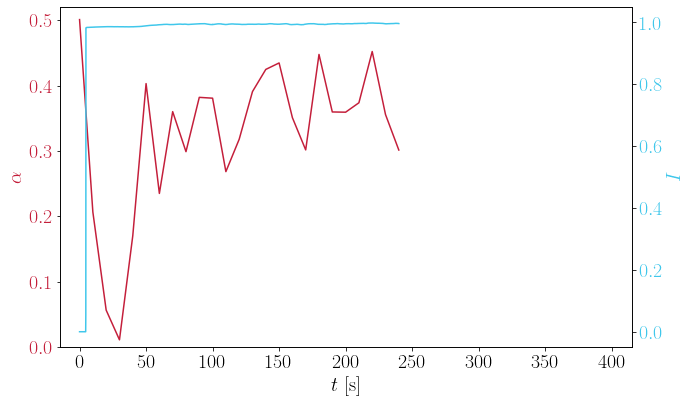

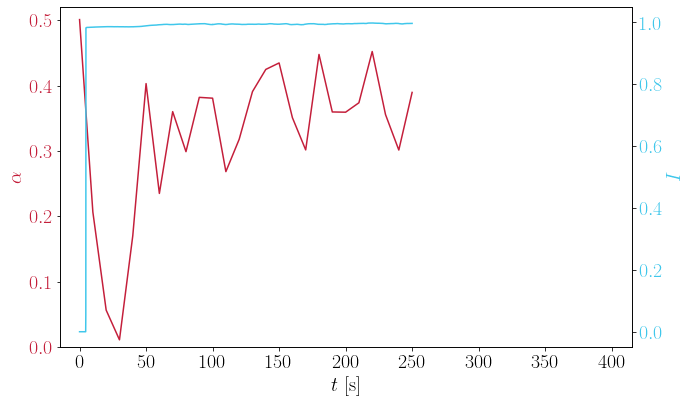

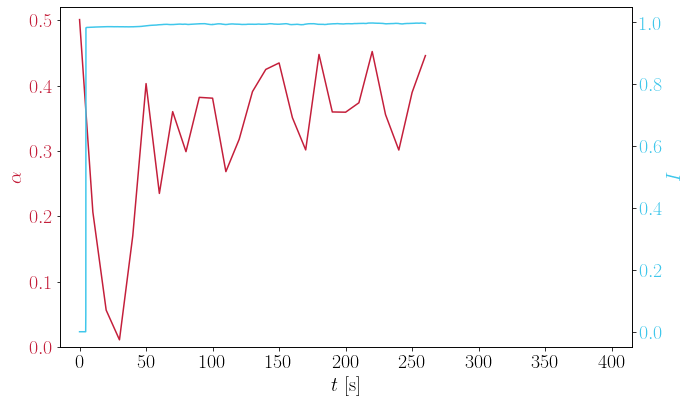

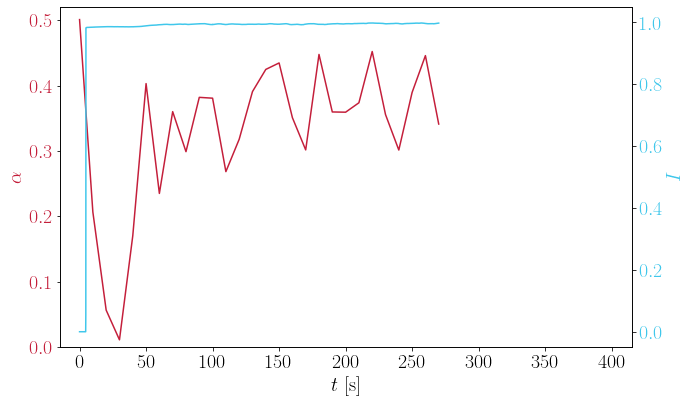

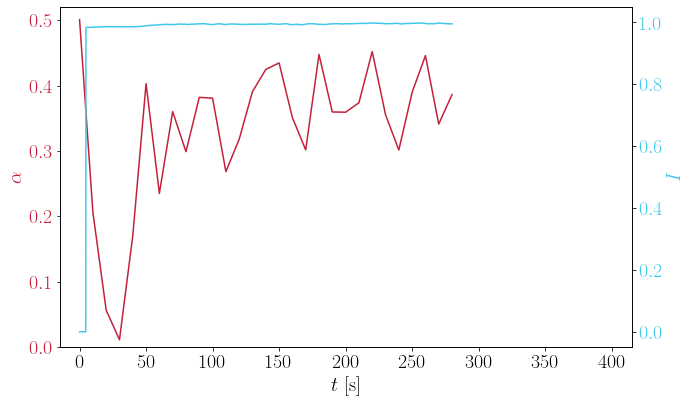

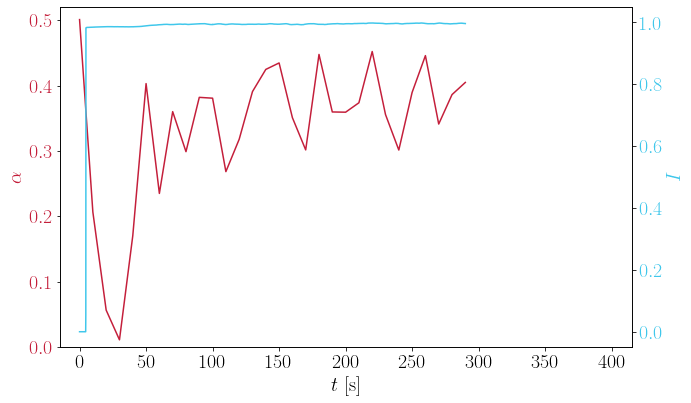

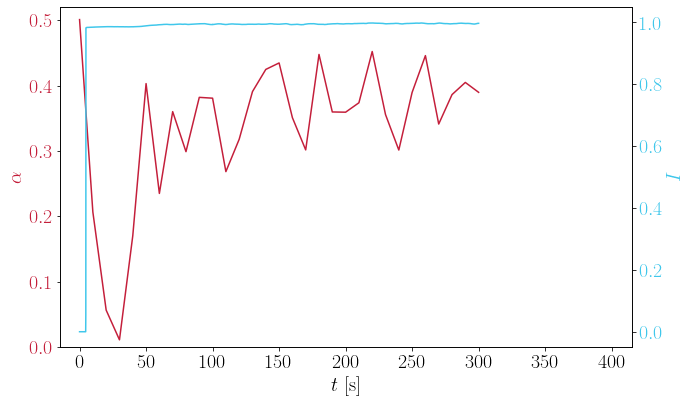

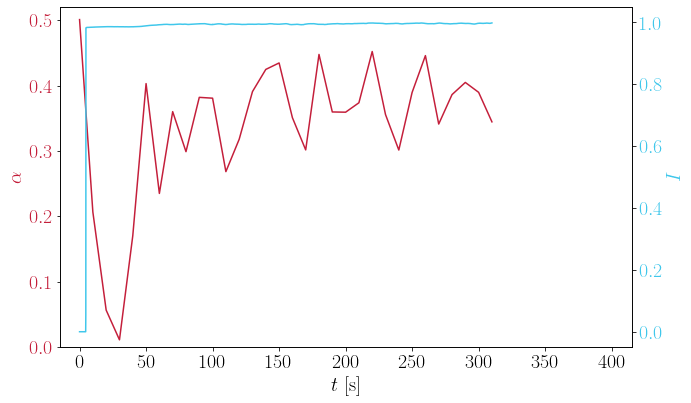

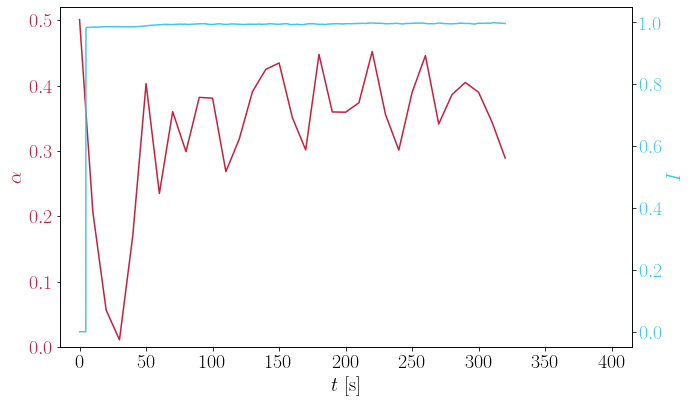

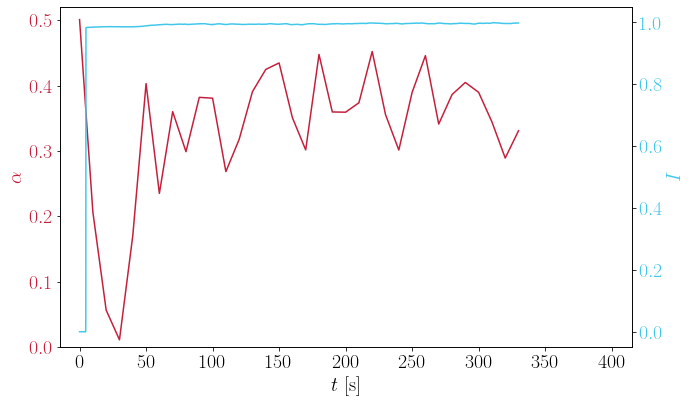

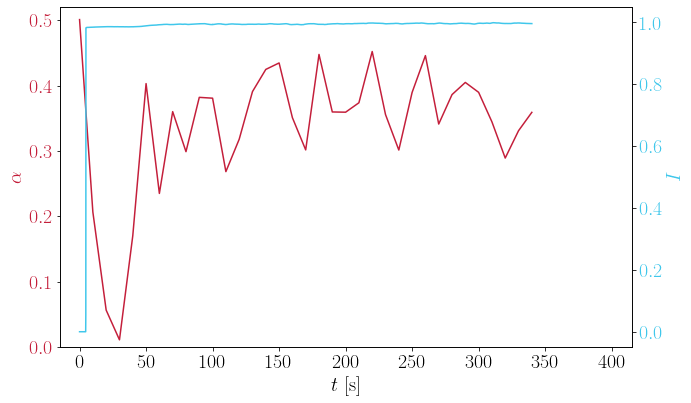

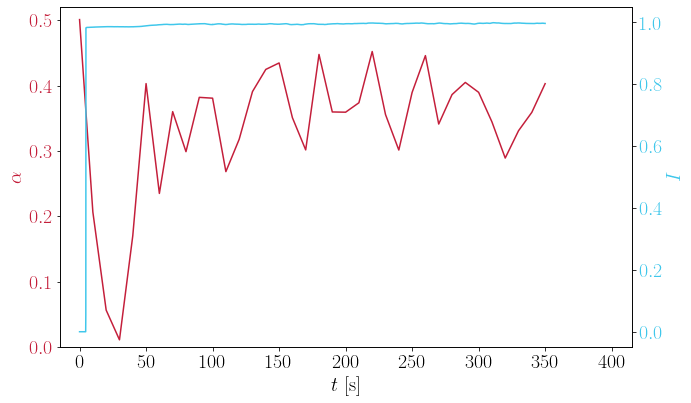

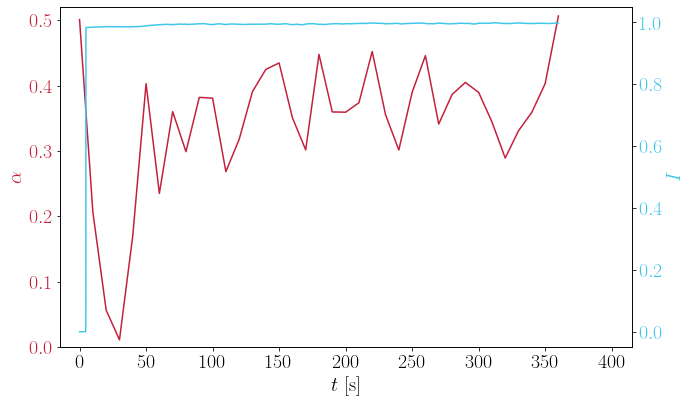

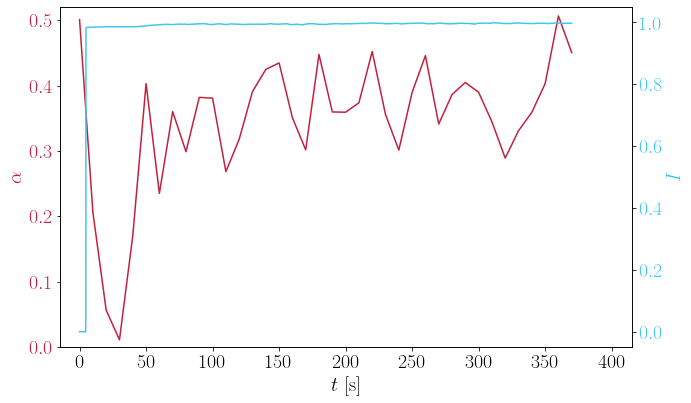

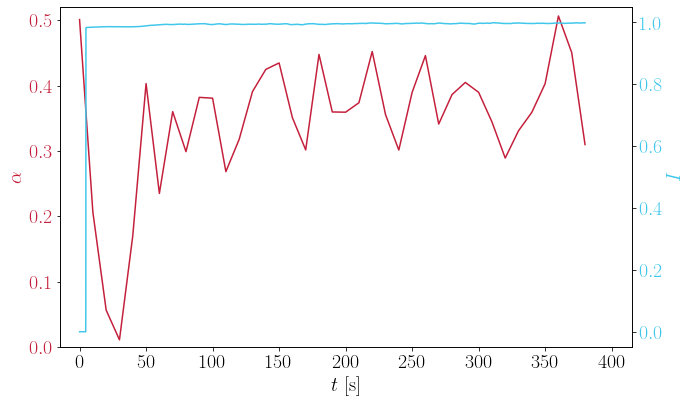

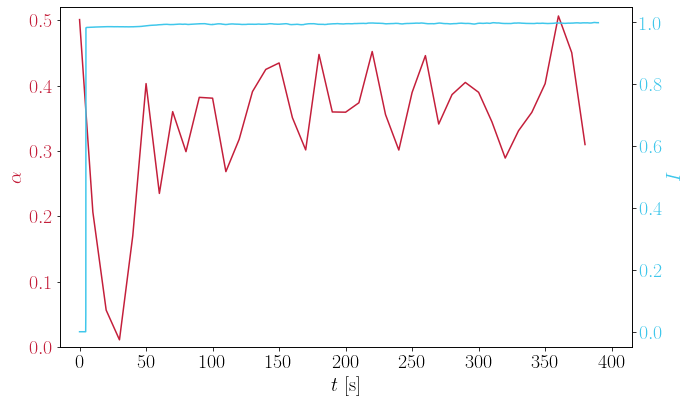

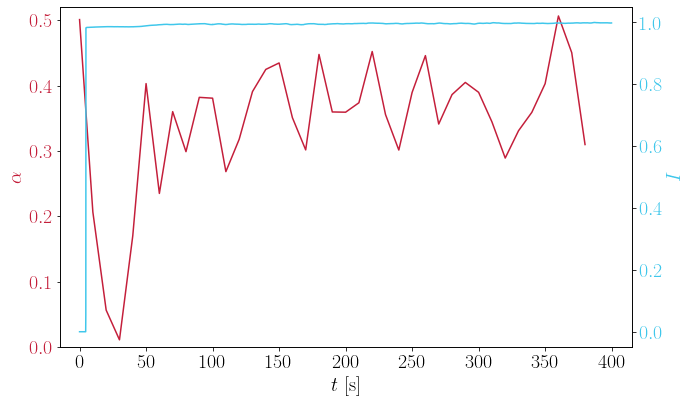

In [34]:
# convert to np.array
t = np.array(t)
power = np.array(power)
t1 = np.array(t1)
i = np.array(i)

# compute lim
tcL = range(0, 410, 10)
for tc in tcL:
    ind = t <= tc
    ind1 = t1 <= tc
    # set up fig and ax
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    # plot t, power
    color = wowcolor(0)
    ax1.set_xlabel('$t$ [s]')
    ax1.set_ylabel('$\\alpha$', color=color)
    ax1.plot(t[ind], power[ind], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlim([-15, 415])
    ax1.set_ylim([0, 0.52])

    # plot t1, intensity
    color = wowcolor(4)
    ax2.set_ylabel('$I$', color=color)
    ax2.plot(t1[ind1], i[ind1], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_xlim([-15, 415])
    ax2.set_ylim([-0.05, 1.05])

    fig.tight_layout()
    fig.savefig(os.path.join(r'E:\Google Drive\Research projects\DF\Figures\fig2-GNF\kinetics_animation', '{0:03d}.png'.format(tc)), format='png', dpi=300)

In [27]:
np.array(t)[ind]

array([ 0., 10., 20., 30., 40., 50.])

In [6]:
def plot_kinetics(k_data, i_data, lb=3, mpp=0.33, seg_length=100, fps=10):
    # plot evolution of number fluctuation exponents and light intensity on a same yyplot
    # refer to https://matplotlib.org/gallery/api/two_scales.html
    t = [] 
    power = []

    # compute exponents at different time
    # t, power will be plotted on ax1
    for idx in k_data.segment.drop_duplicates():
        subdata = k_data.loc[k_data.segment==idx]
        xx = subdata.n / (lb/mpp)**2
        yy = subdata.d / subdata.n**.5
        yy = yy / yy.iat[0]
        index = xx < 100
        xx = xx[index]
        yy = yy[index]
        x = np.log(xx)
        y = np.log(yy)
        p = np.polyfit(x, y, deg=1)
        t.append((idx-1)*seg_length/fps)
        power.append(p[0])

    # rescale light intensity to (0, 1)
    # t1, i will be plotted on ax2
    t1 = i_data.t / fps
    i = i_data.intensity - i_data.intensity.min()
    i = i / i.max()

    # set up fig and ax
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    # plot t, power
    color = wowcolor(0)
    ax1.set_xlabel('$t$ [s]')
    ax1.set_ylabel('$\\alpha$', color=color)
    ax1.plot(t, power, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # plot t1, intensity
    color = wowcolor(4)
    ax2.set_ylabel('$I$', color=color)
    ax2.plot(t1, i, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    return fig, ax1

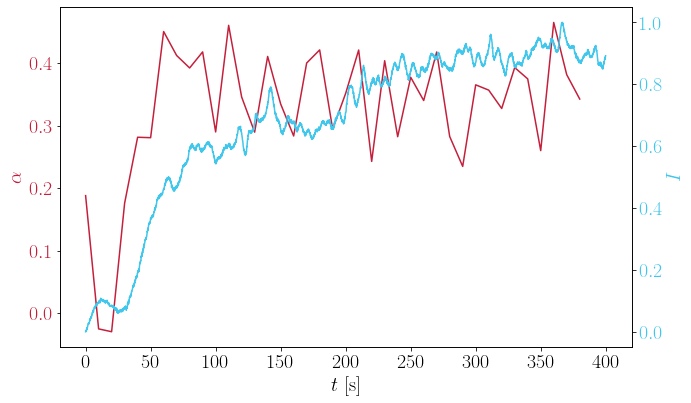

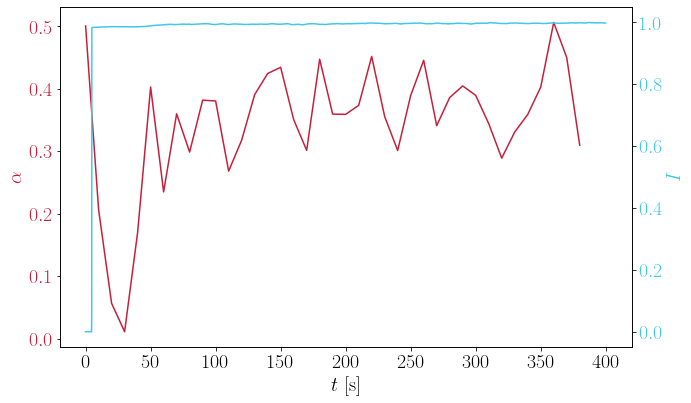

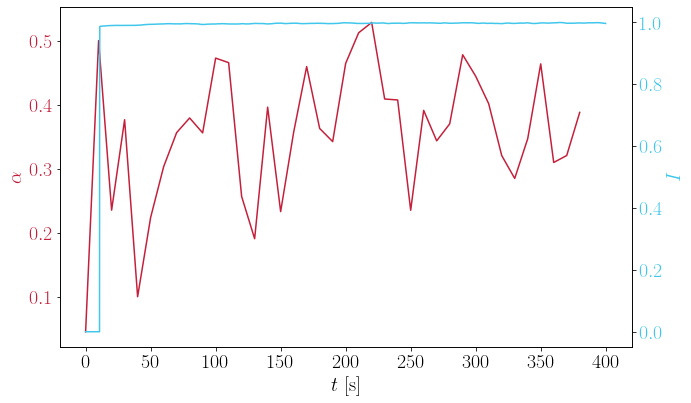

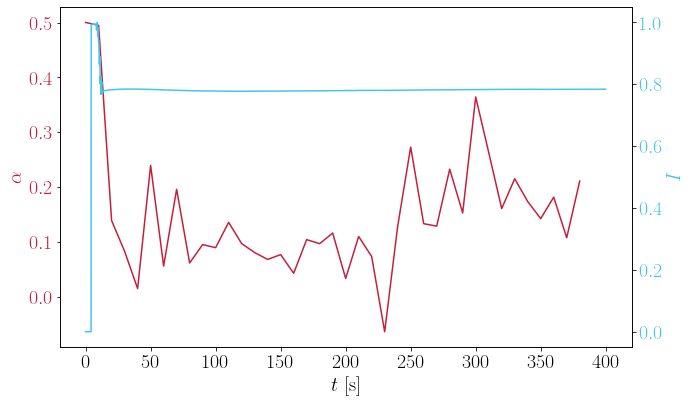

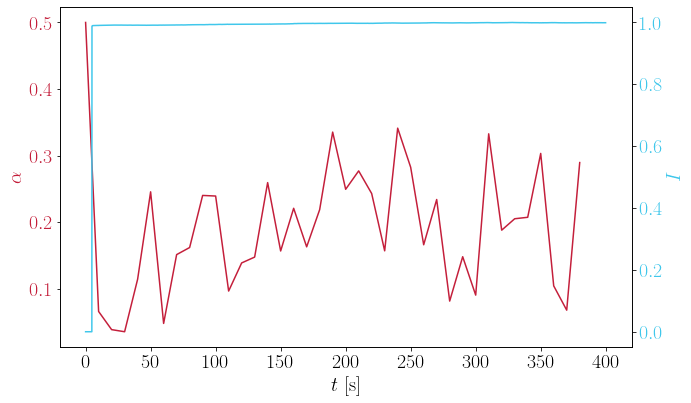

In [26]:
numL = range(0, 5)
for num in numL:
    k_data = pd.read_csv(r'E:\moreData\06232020\df2_kinetics\{0:02d}\kinetics_data.csv'.format(num))
    i_data = pd.read_csv(r'E:\moreData\06232020\overall_intensity\{0:02d}\intensity.csv'.format(num))
    fig, ax = plot_kinetics(k_data, i_data)
    fig.savefig(r'E:\moreData\06232020\kinetics_plots\{0:02d}.png'.format(num), format='png', dpi=300)

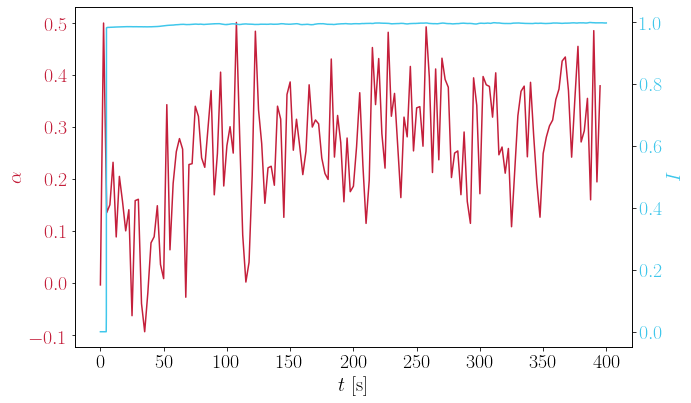

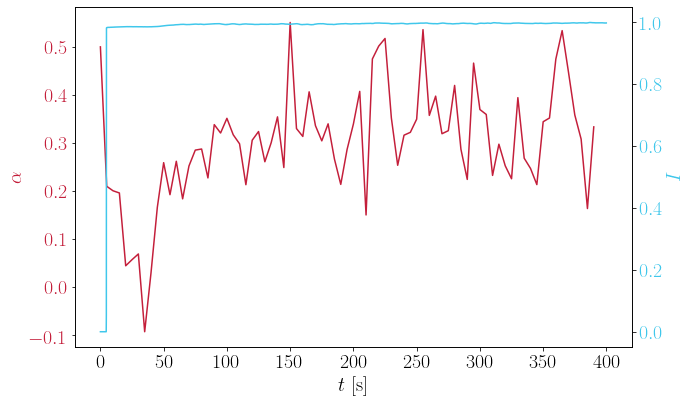

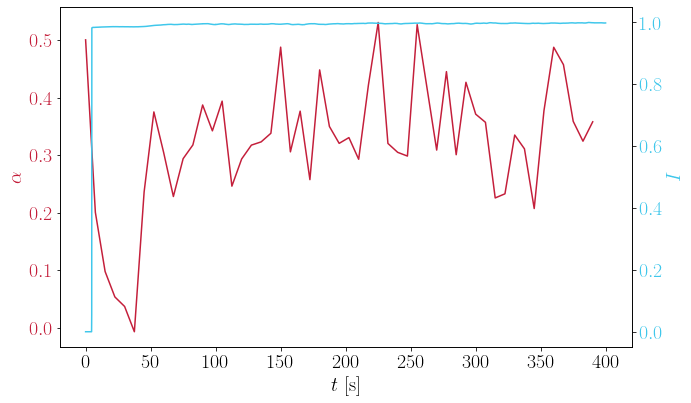

In [33]:
iL = [25, 50, 75]
num = 1
i_data = pd.read_csv(r'E:\moreData\06232020\overall_intensity\{0:02d}\intensity.csv'.format(num))
for i in iL:
    k_data = pd.read_csv(r'E:\moreData\06232020\df2_kinetics\i={0:02d}\{1:02d}\kinetics_data.csv'.format(i, num))
    fig = plot_kinetics(k_data, i_data, seg_length=i)
    fig.savefig(r'E:\moreData\06232020\kinetics_plots\vary_interval\i={0:02d}.png'.format(i), format='png', dpi=300)

# Energy and flow order evolution

In [29]:
# energy
pivData = pd.read_csv(r'E:\moreData\02042020\piv_result_50\80-1\0000-0001.csv')
E = 0
mpp = 0.33
u = pivData.u * mpp
v = pivData.v * mpp
v2 = u**2 + v**2
v2.mean()

In [43]:
# order, write order and energy in one *.py file
pivData = pd.read_csv(r'E:\moreData\02042020\piv_result_50\80-1\0000-0001.csv')
col = len(pivData.x.drop_duplicates())
row = len(pivData.y.drop_duplicates())
u = np.array(pivData.u).reshape((row, col))
v = np.array(pivData.v).reshape((row, col))

In [89]:
shift = np.zeros((row, col))
for i in range(0, min(row, col)):
    shift[i, (i+1)%min(row, col)] = 1

In [90]:
shift

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [57]:
u

array([[  6.43372012,   0.91911662,   0.53773903, ...,  -2.77626692,
         -2.56547945,  -6.54759021],
       [  3.711849  ,  -2.68217164,  -6.02319488, ...,  -3.20129185,
          0.26903991,  -2.22225124],
       [  1.2880826 ,  -3.81062425,  -9.31535777, ...,  -1.48252694,
          3.55980818,  10.726124  ],
       ...,
       [ -2.25187829,  -2.19690032,   2.96406026, ...,  10.485681  ,
         16.42984685,  26.96909081],
       [ -6.10641013,  -7.95773873,  -6.14146324, ...,   0.79577001,
          6.92152602,  15.22735736],
       [-13.41759867, -14.37446971,  -3.06224472, ...,  -5.00692609,
          4.62464469,  11.41528177]])

In [111]:
u3

array([[ -6.54759021,   6.43372012,   0.91911662, ...,  -8.65362172,
         -2.77626692,  -2.56547945],
       [ -2.22225124,   3.711849  ,  -2.68217164, ..., -15.9280852 ,
         -3.20129185,   0.26903991],
       [ 10.726124  ,   1.2880826 ,  -3.81062425, ...,  -2.26578641,
         -1.48252694,   3.55980818],
       ...,
       [ 26.96909081,  -2.25187829,  -2.19690032, ...,   9.91560288,
         10.485681  ,  16.42984685],
       [ 15.22735736,  -6.10641013,  -7.95773873, ...,  -2.38486166,
          0.79577001,   6.92152602],
       [ 11.41528177, -13.41759867, -14.37446971, ...,  -8.53161694,
         -5.00692609,   4.62464469]])

In [88]:
np.matmul(u, shift.transpose())

array([[  0.91911662,   0.53773903,   4.67957242, ...,  -2.56547945,
         -6.54759021,   6.43372012],
       [ -2.68217164,  -6.02319488,  -5.17899917, ...,   0.26903991,
         -2.22225124,   3.711849  ],
       [ -3.81062425,  -9.31535777,  -8.85892138, ...,   3.55980818,
         10.726124  ,   1.2880826 ],
       ...,
       [ -2.19690032,   2.96406026,   8.98030573, ...,  16.42984685,
         26.96909081,  -2.25187829],
       [ -7.95773873,  -6.14146324,   0.59770191, ...,   6.92152602,
         15.22735736,  -6.10641013],
       [-14.37446971,  -3.06224472,   2.66336345, ...,   4.62464469,
         11.41528177, -13.41759867]])

In [81]:
def inner(Ax, Ay, Bx, By):
    return (Ax*Bx + Ay*By) / (Ax**2+Ay**2)**0.5 / (Bx**2+By**2)**0.5

In [91]:
Ax = u
Ay = v
Bx = np.matmul(shift, u)
By = np.matmul(shift, v)
inner(Ax, Ay, Bx, By)

array([[ 0.47951546,  0.51917257,  0.59760755, ...,  0.99998922,
         0.99819857,  0.99638698],
       [ 0.73918731,  0.32411844,  0.82841416, ...,  0.99959309,
         0.99577414,  0.87657278],
       [ 0.81641258,  0.77031251,  0.9136053 , ...,  0.998618  ,
         0.99030391,  0.99343575],
       ...,
       [ 0.9850008 ,  0.9423613 ,  0.9270966 , ...,  0.92725904,
         0.93048323,  0.89711268],
       [ 0.99337647,  0.98082624,  0.99929578, ...,  0.98455529,
         0.99865779,  0.95153863],
       [-0.78752285, -0.86791403, -0.98786376, ..., -0.979547  ,
        -0.99808872, -0.97679785]])

In [92]:
u1 = np.matmul(shift, u)
v1 = np.matmul(shift, v)
u2 = np.matmul(shift.transpose(), u)
v2 = np.matmul(shift.transpose(), v)
u3 = np.matmul(u, shift)
v3 = np.matmul(v, shift)
u4 = np.matmul(u, shift.transpose())
v4 = np.matmul(v, shift.transpose())

In [95]:
I1 = inner(u, v, u1, v1)
I2 = inner(u, v, u2, v2)
I3 = inner(u, v, u3, v3)
I4 = inner(u, v, u4, v4)

In [96]:
I = (I1 + I2 + I3 + I4) / 4

In [98]:
I_roi = I[1:row-1, 1:col-1]

In [100]:
I_roi[I_roi < .9] = 0

In [104]:
np.count_nonzero(I_roi) / col / row

0.68296875

# Plot energy, order and GNF together

In [11]:
ax

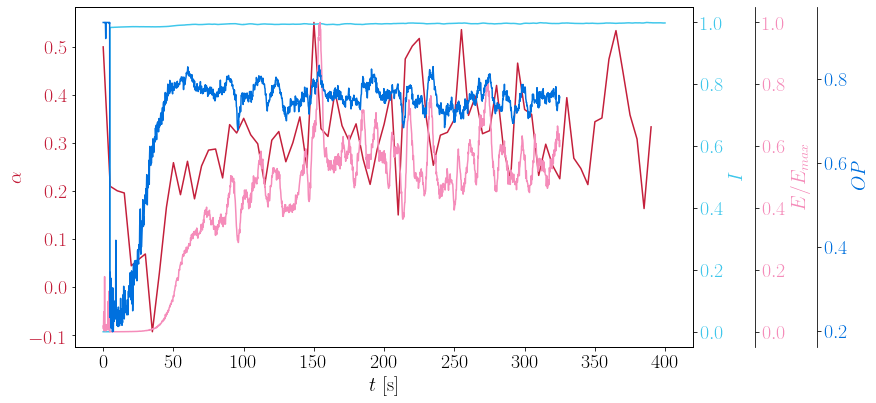

In [25]:
matplotlib.rcParams['figure.figsize'] = 13, 6
eo = pd.read_csv(r'E:\moreData\06232020\energy_order\01\energy_order.csv')
k = pd.read_csv(r'E:\moreData\06232020\df2_kinetics\i=50\01\kinetics_data.csv')
i = pd.read_csv(r'E:\moreData\06232020\overall_intensity\01\intensity.csv')
fig, ax = plot_kinetics(k, i, seg_length=50)
ax1 = ax.twinx()
color = wowcolor(6)
ax1.set_ylabel('$E/E_{max}$', color=color)
ax1.plot(eo.t, eo.E/eo.E.max(), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.spines["right"].set_position(("axes", 1.1))
ax2 = ax.twinx()
color = wowcolor(8)
ax2.set_ylabel('$OP$', color=color)
ax2.plot(eo.t, eo.OP, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.spines["right"].set_position(("axes", 1.2))
plt.tight_layout()
fig.savefig(r'E:\Google Drive\Research projects\DF\Figures\fig2-GNF\kinetics_E_OP\60n0.png', dpi=300, fmt='png')

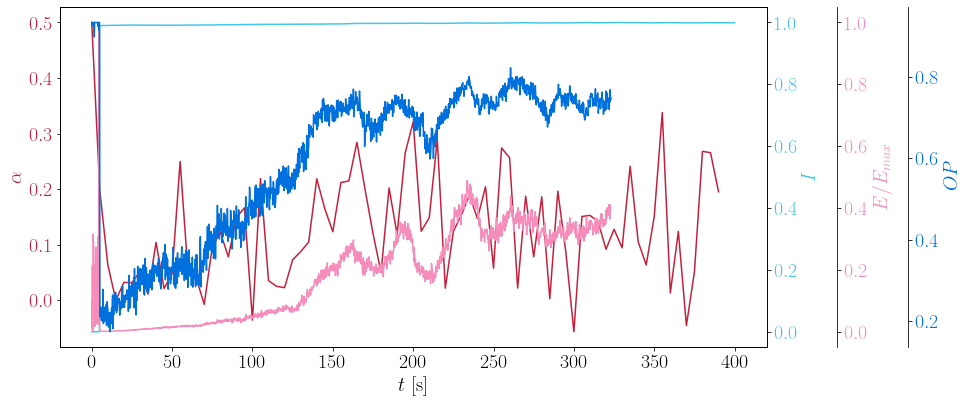

In [27]:
eo = pd.read_csv(r'E:\moreData\06232020\energy_order\04\energy_order.csv')
k = pd.read_csv(r'E:\moreData\06232020\df2_kinetics\i=50\04\kinetics_data.csv')
i = pd.read_csv(r'E:\moreData\06232020\overall_intensity\04\intensity.csv')
fig, ax = plot_kinetics(k, i, seg_length=50)
ax1 = ax.twinx()
color = wowcolor(6)
ax1.set_ylabel('$E/E_{max}$', color=color)
ax1.plot(eo.t, eo.E/eo.E.max(), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.spines["right"].set_position(("axes", 1.1))
ax2 = ax.twinx()
color = wowcolor(8)
ax2.set_ylabel('$OP$', color=color)
ax2.plot(eo.t, eo.OP, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.tight_layout()
ax2.spines["right"].set_position(("axes", 1.2))
fig.savefig(r'E:\Google Drive\Research projects\DF\Figures\fig2-GNF\kinetics_E_OP\30n0.png', dpi=300, fmt='png')